# Lab Six: Convolutional Neural Networks (CNNs)

By: Abhilash Arnipalli

In [1]:
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

In [2]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


# Preparation

## Evaluation Metric

I will employ accuracy as the primary metric to evaluate my algorithm's performance. The rationale behind this choice stems from the balanced distribution of classes in my dataset, where there is no discernible advantage, from a business perspective, in predicting one class over the others. Given this context, accuracy provides a comprehensive measure of the model's overall correctness in classifying instances. Moreover, accuracy or its variations are consistently utilized and widely accepted in similar image classification problems, such as ImageNet.

In terms of my own decision-making I believe accuracy is a suitable metric because it aligns with the business objectives of achieving a well-rounded and unbiased classification across all classes. The balanced nature of the dataset ensures that each class contributes equally to the evaluation, and accuracy reflects the model's proficiency in making correct predictions across the entire spectrum of classes.
Reflecting on the broader landscape of image classification problems, especially drawing parallels with renowned benchmarks like ImageNet, accuracy emerges as a prevalent and accepted metric. This prevalence not only underscores its relevance but also facilitates comparisons and benchmarking against established standards in the field.

## Loading the Dataset

In [3]:
dir = "cifar-10-batches-py/"
files = ["data_batch_1", "data_batch_2", "data_batch_3", "data_batch_4", "data_batch_5", "test_batch"]
# For each batch file read the content with pickle and encoding bytes because the CIFAR-10 dataset is stored as bytes.
for file in files:
    with open(dir + file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        if file == "data_batch_1":
            data = dict[b'data']
            labels = dict[b'labels']
        else:
            data = np.vstack((data, dict[b'data']))
            labels = np.hstack((labels, dict[b'labels']))
data = data.reshape((data.shape[0], 3, 32, 32)).transpose(0, 2, 3, 1).astype("int")

### Visualize Images from the Dataset

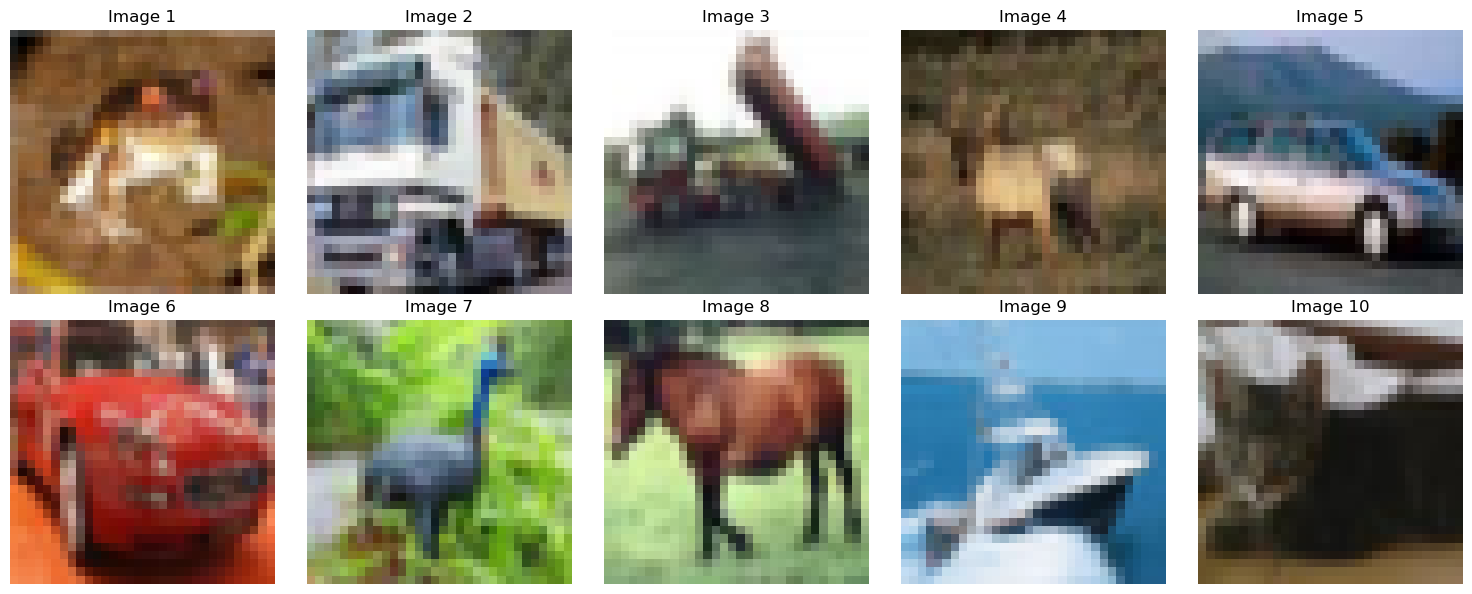

In [4]:
import matplotlib.pyplot as plt

# Plot the first 10 images in the dataset
num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        axes[i, j].imshow(data[index], interpolation='nearest')
        axes[i, j].set_title(f"Image {index + 1}")
        axes[i, j].axis('off')
plt.tight_layout()
plt.show()

## Method for Dividing and Testing the data

I will implement a stratified train-test split for my data. With a substantial dataset of 60,000 images equally distributed across 10 classes, there is no necessity to employ K-fold cross-validation or shuffle split for effective model training and evaluation.

I chose the stratified train-test split method because it ensures that the distribution of classes in both the training and testing sets mirrors the overall distribution in the entire dataset. This approach is appropriate for my scenario as it reflects a realistic representation of how the algorithm would be used in practical applications. By maintaining the balance of classes in the training and testing sets, I aim to create a model that generalizes well to diverse instances, ensuring its robustness in real-world scenarios.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=69, stratify=labels)

# Modeling

In [6]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], color='blue')
    plt.plot(history.history['val_accuracy'], color='red')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

## Data Expansion in Keras

I will configure the training to incorporate data augmentation in Keras, utilizing augmentation layers similar to the examples covered in class. I believe that the chosen data expansion techniques are suitable for my dataset based on the nature of the classes, which comprise everyday objects typically observed in regular orientations. In practical scenarios, these objects are not expected to appear upside down, so I don't find vertical flipping necessary.

However, considering the potential for variations in horizontal orientations and the likelihood of objects appearing in different positions within the frame in real-world settings, it makes sense to include horizontal flipping in the augmentation process. Additionally, accounting for slight variations in both the angle and position of the objects during training is crucial to enhance the model's ability to generalize effectively to diverse scenarios. Therefore, I will adjust for these factors using appropriate augmentation techniques in Keras.

In [7]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
)

datagen.fit(X_train)

## Model 1

In [8]:
# Define an input layer with a shape of 32x32 pixels and 3 color channels (RGB)
input = tf.keras.Input(shape=(32, 32, 3))

# Normalizes the input values to the range [0, 1] by dividing each pixel value by 255
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# Applies a convolutional layer with 64 filters of size 3x3 using the ReLU activation function.
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)

# Applies max pooling with a pool size of 2x2 to reduce the spatial dimensions of the feature maps
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Flattens the 2D feature maps into a 1D array to prepare for fully connected layers
dense = tf.keras.layers.Flatten()(x)

# Two fully connected (dense) layers with 64 and 16 neurons using the ReLU activation function
dense = tf.keras.layers.Dense(64, activation='relu')(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)
model1 = tf.keras.Model(inputs=input, outputs=output)

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Trains the model using data augmentation 
# It trains for 20 epochs using batches of size 256 and validates on the validation set (X_val, y_val)
history1 = model1.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
188/188 [==============================] - 9s 48ms/step - loss: 2.0753 - accuracy: 0.2141 - val_loss: 1.8949 - val_accuracy: 0.2970
Epoch 2/20
188/188 [==============================] - 9s 48ms/step - loss: 1.7385 - accuracy: 0.3603 - val_loss: 1.5701 - val_accuracy: 0.4206
Epoch 3/20
188/188 [==============================] - 10s 52ms/step - loss: 1.5434 - accuracy: 0.4351 - val_loss: 1.4747 - val_accuracy: 0.4575
Epoch 4/20
188/188 [==============================] - 9s 49ms/step - loss: 1.4672 - accuracy: 0.4650 - val_loss: 1.4112 - val_accuracy: 0.4903
Epoch 5/20
188/188 [==============================] - 9s 48ms/step - loss: 1.3999 - accuracy: 0.4892 - val_loss: 1.3689 - val_accuracy: 0.5066
Epoch 6/20
188/188 [==============================] - 9s 48ms/step - loss: 1.3629 - accuracy: 0.5091 - val_loss: 1.2836 - val_accuracy: 0.5358
Epoch 7/20
188/188 [==============================] - 9s 49ms/step - loss: 1.3306 - accuracy: 0.5181 - val_loss: 1.2635 - val_accuracy: 0.547

In [9]:
# Save Model 1
model1.save('model1.h5')

/Users/AbhilashArnipalli/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Model 1 Visualization:

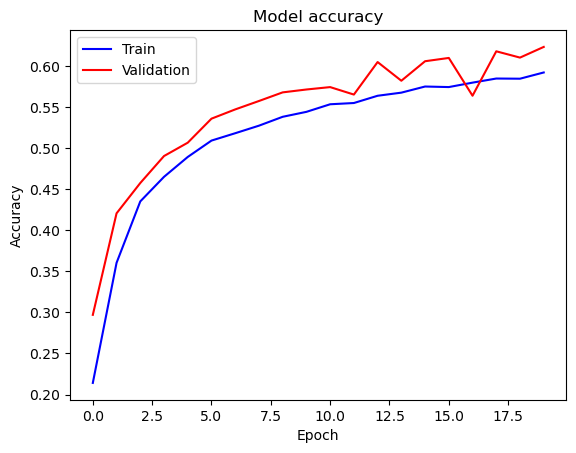

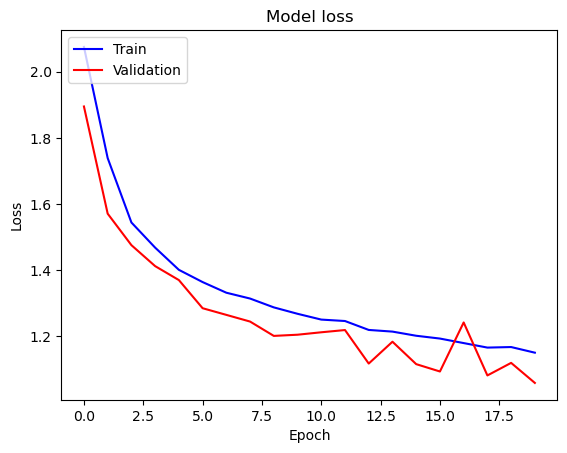

In [10]:
# Generates plot for the training and validation accuracy and loss over epochs
plot_history(history1)

In the graph above we can see that as the train and validation loss graphs diverge the accuracy of it reaches a high of about 65% and the training accuracy reaches a high of above 62% which is not ideal. This may be due to the model overfitting which can be fixed with dropout in Model 2.

## Model 2

In [11]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], color='blue')
    plt.plot(history.history['val_accuracy'], color='red')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [12]:
input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(normalized_input)

# Apply dropout regularization with a rate of 0.2 to the convolutional layer
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
dense = tf.keras.layers.Flatten()(x)
dense = tf.keras.layers.Dense(64, activation='relu')(dense)

# Apply dropout regularization with a rate of 0.2 to the dense layer
dense = tf.keras.layers.Dropout(0.2)(dense)
dense = tf.keras.layers.Dense(16, activation='relu')(dense)
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

# Create the model 
model2 = tf.keras.Model(inputs=input, outputs=output)

# Compile the model 
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using data augmentation for 30 epochs and validate on the validation set
history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=256), epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
188/188 [==============================] - 11s 58ms/step - loss: 2.0566 - accuracy: 0.2229 - val_loss: 1.7692 - val_accuracy: 0.3415
Epoch 2/30
188/188 [==============================] - 11s 57ms/step - loss: 1.7504 - accuracy: 0.3417 - val_loss: 1.5706 - val_accuracy: 0.4315
Epoch 3/30
188/188 [==============================] - 11s 57ms/step - loss: 1.6361 - accuracy: 0.3845 - val_loss: 1.5117 - val_accuracy: 0.4597
Epoch 4/30
188/188 [==============================] - 11s 57ms/step - loss: 1.5699 - accuracy: 0.4088 - val_loss: 1.4784 - val_accuracy: 0.4749
Epoch 5/30
188/188 [==============================] - 11s 57ms/step - loss: 1.5229 - accuracy: 0.4325 - val_loss: 1.3774 - val_accuracy: 0.5077
Epoch 6/30
188/188 [==============================] - 11s 57ms/step - loss: 1.5015 - accuracy: 0.4411 - val_loss: 1.3786 - val_accuracy: 0.5121
Epoch 7/30
188/188 [==============================] - 11s 58ms/step - loss: 1.4712 - accuracy: 0.4528 - val_loss: 1.2999 - val_accuracy:

In [13]:
# Save Model 2
model2.save('model2.h5')

### Model 2 Visualization:

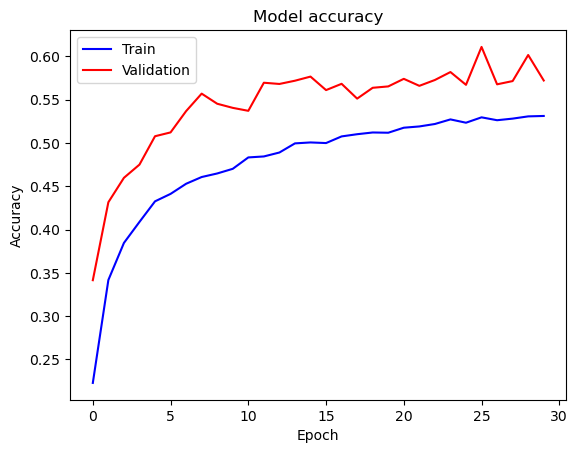

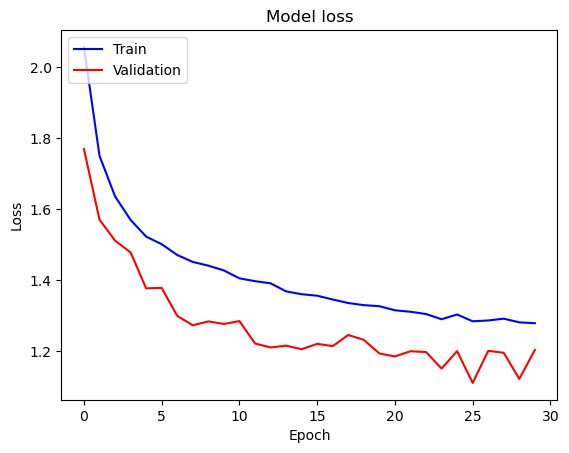

In [14]:
plot_history(history2)

From the visualization above, after dropout was added I can see that there is not much divergence between train loss and validation loss. Now the validation accuracy and loss are about the same. 

## Compare Model 1 and Model 2

In [15]:
import numpy as np
from scipy.stats import chi2
import math

# Predictions for model1 and model2 on the validation set
y_pred_model1 = model1.predict(X_val)
y_pred_model2 = model2.predict(X_val)

# Extract the predicted classes (argmax) from the predicted probabilities
y_pred_model1 = np.argmax(y_pred_model1, axis=1)
y_pred_model2 = np.argmax(y_pred_model2, axis=1)

# Count the number of correct predictions for each model
model1_correct = np.sum((y_pred_model1 == y_val) & (y_pred_model2 != y_val))
model2_correct = np.sum((y_pred_model2 == y_val) & (y_pred_model1 != y_val))

# Calculate the critical value for the chi-squared test
critical_value = (model1_correct + model2_correct)**2 / (model1_correct + model2_correct)

# Perform the chi-squared test and calculate the p-value
p_value = 1 - chi2.cdf(math.sqrt(critical_value), 1)

375/375 [==============================] - 1s 3ms/step


In [16]:
p_value

1.0363931934875836e-12

The p-value from the test is close to zero. This test proves that the models are not the same.

## Model 3

In [17]:
def plot_history(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'], color='blue')
    plt.plot(history.history['val_accuracy'], color='red')
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [18]:
import tensorflow as tf

# Define the input layer with a shape of (32, 32, 3) for 32x32 RGB images
input = tf.keras.Input(shape=(32, 32, 3))

# Normalize the input values to the range [0, 1]
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# Stack multiple convolutional layers with batch normalization and dropout
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)

# Flatten the 2D feature maps into a 1D array
dense = tf.keras.layers.Flatten()(x)

# Apply a fully connected (dense) layer with 32 neurons and ReLU activation
dense = tf.keras.layers.Dense(32, activation='relu')(dense)

# Define the output layer with 10 neurons and softmax activation for classification
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

# Create the model using the defined input and output layers
model3 = tf.keras.Model(inputs=input, outputs=output)

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model3.summary()

# Train the model using data augmentation for 35 epochs and validate on the validation set
history3 = model3.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 16)        64        
 Normalization)                                                  
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 16)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        2320      
                                                           

94/94 [==============================] - 28s 293ms/step - loss: 1.2734 - accuracy: 0.5399 - val_loss: 1.1598 - val_accuracy: 0.5864
Epoch 29/35
94/94 [==============================] - 28s 297ms/step - loss: 1.2690 - accuracy: 0.5409 - val_loss: 1.2972 - val_accuracy: 0.5204
Epoch 30/35
94/94 [==============================] - 27s 288ms/step - loss: 1.2543 - accuracy: 0.5454 - val_loss: 1.1655 - val_accuracy: 0.5881
Epoch 31/35
94/94 [==============================] - 27s 285ms/step - loss: 1.2520 - accuracy: 0.5436 - val_loss: 1.1649 - val_accuracy: 0.5869
Epoch 32/35
94/94 [==============================] - 28s 297ms/step - loss: 1.2434 - accuracy: 0.5508 - val_loss: 1.1324 - val_accuracy: 0.6052
Epoch 33/35
94/94 [==============================] - 27s 288ms/step - loss: 1.2465 - accuracy: 0.5494 - val_loss: 1.2942 - val_accuracy: 0.5315
Epoch 34/35
94/94 [==============================] - 27s 283ms/step - loss: 1.2434 - accuracy: 0.5513 - val_loss: 1.2671 - val_accuracy: 0.5418
Epoc

In [19]:
# Save Model 3
model3.save('model3.h5')

### Model 3 Visualization:

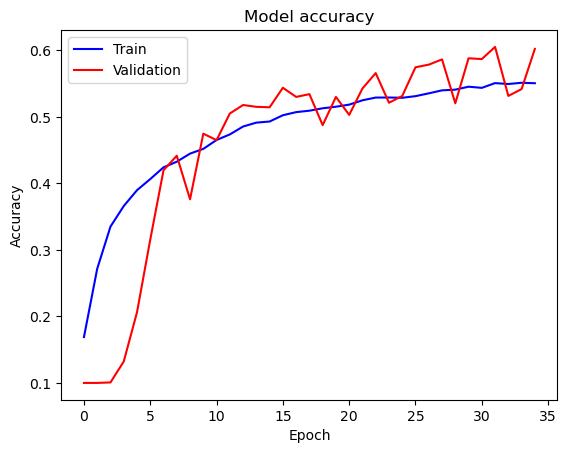

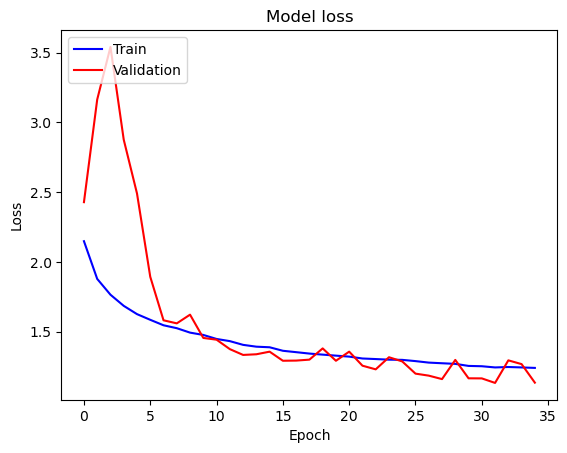

In [20]:
plot_history(history3)

From the visualization of the Model above, we can see that the training and validation loss converge. The accuracy of validation is worse than model 1 and model 2 with an accuracy of about 60%. To approach this issue, the next model will include more advanced filters.

## Model 4

In [21]:
import tensorflow as tf

# Define the input layer with a shape of (32, 32, 3) for 32x32 RGB images
input = tf.keras.Input(shape=(32, 32, 3))

# Normalize the input values to the range [0, 1]
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

# Stack multiple convolutional layers with batch normalization and dropout
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(normalized_input)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

# Flatten the 2D feature maps into a 1D array
dense = tf.keras.layers.Flatten()(x)

# Apply a fully connected (dense) layer with 64 neurons and ReLU activation
dense = tf.keras.layers.Dense(64, activation='relu')(dense)

# Define the output layer with 10 neurons and softmax activation for classification
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

# Create the model using the defined input and output layers
model4 = tf.keras.Model(inputs=input, outputs=output)

# Compile the model with Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using data augmentation for 35 epochs and validate on the validation set
history4 = model4.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=35, validation_data=(X_val, y_val))

Epoch 1/35
94/94 [==============================] - 222s 2s/step - loss: 2.1856 - accuracy: 0.1610 - val_loss: 2.4603 - val_accuracy: 0.1000
Epoch 2/35
94/94 [==============================] - 223s 2s/step - loss: 1.7970 - accuracy: 0.3045 - val_loss: 2.6841 - val_accuracy: 0.1013
Epoch 3/35
94/94 [==============================] - 228s 2s/step - loss: 1.5958 - accuracy: 0.4036 - val_loss: 2.5649 - val_accuracy: 0.1066
Epoch 4/35
94/94 [==============================] - 221s 2s/step - loss: 1.4574 - accuracy: 0.4617 - val_loss: 2.2892 - val_accuracy: 0.1647
Epoch 5/35
94/94 [==============================] - 221s 2s/step - loss: 1.3625 - accuracy: 0.5068 - val_loss: 1.8788 - val_accuracy: 0.3023
Epoch 6/35
94/94 [==============================] - 221s 2s/step - loss: 1.2822 - accuracy: 0.5367 - val_loss: 1.6680 - val_accuracy: 0.3995
Epoch 7/35
94/94 [==============================] - 220s 2s/step - loss: 1.2216 - accuracy: 0.5620 - val_loss: 1.2280 - val_accuracy: 0.5644
Epoch 8/35
94

In [22]:
model4.save('model4.h5')

### Model 4 Visualization:

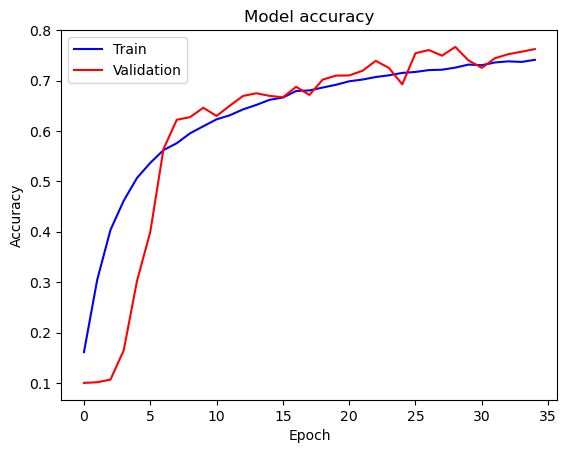

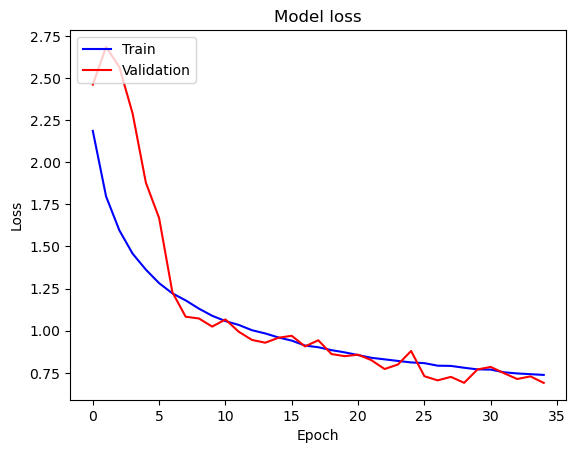

In [23]:
plot_history(history4)

From the visualization above, I can now see that the CNN converges at a significantly lower loss of training and validation than previously. The network sees a drastic increase in validation loss and accuracy now as compared to the previous models as it the loss is around 75% and the accuracy is around 74%..

## Performance of CNN compared to Standard MLP

In [24]:
import tensorflow as tf

input = tf.keras.Input(shape=(32, 32, 3))
normalized_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)


flattened_input = tf.keras.layers.Flatten()(normalized_input)

# Apply a fully connected (dense) layer with 1024 neurons and ReLU activation
dense = tf.keras.layers.Dense(1024, activation='relu')(flattened_input)
# Apply another fully connected (dense) layer with 512 neurons and ReLU activation
dense = tf.keras.layers.Dense(512, activation='relu')(dense)
# Apply another fully connected (dense) layer with 256 neurons and ReLU activation
dense = tf.keras.layers.Dense(256, activation='relu')(dense)
# Define the output layer with 10 neurons and softmax activation for classification
output = tf.keras.layers.Dense(10, activation='softmax')(dense)

# Create and compile the model 
mlpModel = tf.keras.Model(inputs=input, outputs=output)
mlpModel.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using data augmentation for 23 epochs and validate on the validation set
mlpHistory = mlpModel.fit(datagen.flow(X_train, y_train, batch_size=512), epochs=23, validation_data=(X_val, y_val))

Epoch 1/23
94/94 [==============================] - 9s 94ms/step - loss: 2.0923 - accuracy: 0.2493 - val_loss: 1.8695 - val_accuracy: 0.3303
Epoch 2/23
94/94 [==============================] - 9s 91ms/step - loss: 1.8312 - accuracy: 0.3434 - val_loss: 1.7685 - val_accuracy: 0.3593
Epoch 3/23
94/94 [==============================] - 8s 90ms/step - loss: 1.7430 - accuracy: 0.3751 - val_loss: 1.6980 - val_accuracy: 0.3950
Epoch 4/23
94/94 [==============================] - 9s 91ms/step - loss: 1.6960 - accuracy: 0.3918 - val_loss: 1.6520 - val_accuracy: 0.4141
Epoch 5/23
94/94 [==============================] - 9s 91ms/step - loss: 1.6468 - accuracy: 0.4094 - val_loss: 1.6014 - val_accuracy: 0.4251
Epoch 6/23
94/94 [==============================] - 9s 91ms/step - loss: 1.6242 - accuracy: 0.4155 - val_loss: 1.5518 - val_accuracy: 0.4474
Epoch 7/23
94/94 [==============================] - 8s 90ms/step - loss: 1.5936 - accuracy: 0.4290 - val_loss: 1.5548 - val_accuracy: 0.4491
Epoch 8/23
94

In [25]:
mlpModel.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 flatten_4 (Flatten)         (None, 3072)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              3146752   
                                                                 
 dense_11 (Dense)            (None, 512)               524800    
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 10)                2570

In [26]:
# Save MLP Model
mlpModel.save('mlpModel.h5')

### Standard MLP Model Visualization:

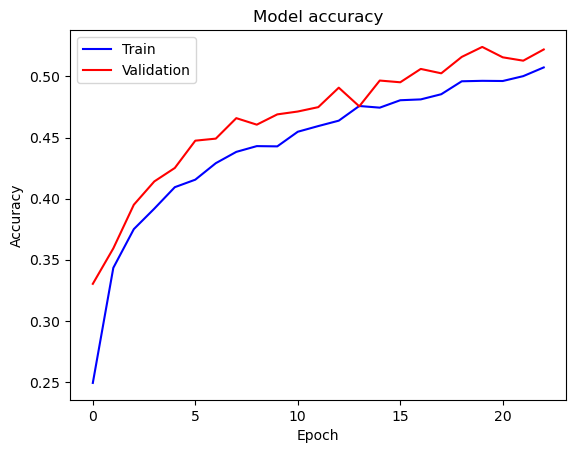

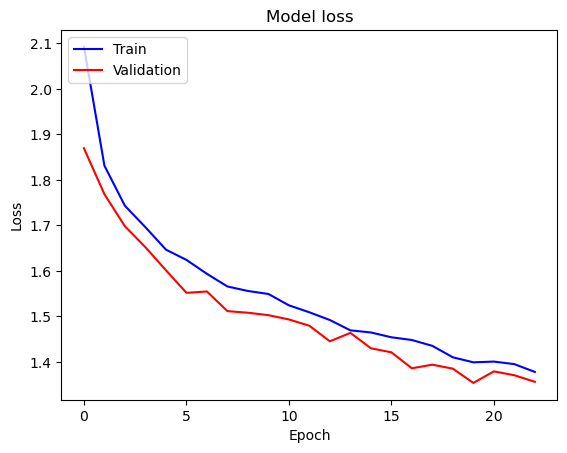

In [27]:
plot_history(mlpHistory)

From the visualization above, I can see that the validation loss reaches convergence near 15 epochs but the training loss sees a drastic divergence from validation. The MLP is only 5 layers deep but it has all layers fully connected making it succeptible to overfitting as seen before. The validation loss can now be seen reaching convergence around 1.35 and the accuracy of validation is around 53%.

## Comparison the results of all 5 Models

In [28]:
model1 = tf.keras.models.load_model('model1.h5')
model2 = tf.keras.models.load_model('model2.h5')
model3 = tf.keras.models.load_model('model3.h5')
model4 = tf.keras.models.load_model('model4.h5')
mlpModel = tf.keras.models.load_model('mlpModel.h5')

In [29]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate average Area Under Curve across all classes
def averageArea(model):
    global y_val
    global X_val
    y_pred = model.predict(X_val)
    y_pred_guess = np.argmax(y_pred, axis=1)
    sum = 0

    for i in range(10):
        y_val_one = np.where(y_val != i, 0, 1)
        y_pred_one = y_pred[:,i]
        fpr, tpr, trash = roc_curve(y_val_one, y_pred_one)
        sum += auc(fpr, tpr)

    return sum/10

# Function to plot ROC curve for each class
def plotCurves(model):
    global y_val
    global X_val
    y_pred = model.predict(X_val)
    y_pred_guess = np.argmax(y_pred, axis=1)
    for i in range(10):
        y_val_one = np.where(y_val != i, 0, 1)
        y_pred_one = y_pred[:,i]

        fpr, tpr, trash = roc_curve(y_val_one, y_pred_one)
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Class {} (Area = {:.2f})'.format(i, auc_score))
    
    plt.legend()
    plt.xlabel('False Positives')
    plt.ylabel('True Positives')
    plt.title('ROC Curve')
    plt.show()

### Model 4 Average AUC Visualization:

375/375 [==============================] - 16s 42ms/step
Average Area Under the Curve for Model 4: 0.9730882098765432
375/375 [==============================] - 16s 42ms/step


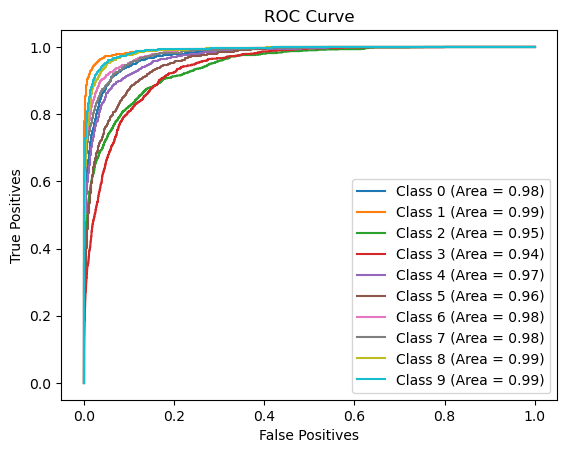

In [30]:
print("Average Area Under the Curve for Model 4: " + str(averageArea(model4)))
plotCurves(model4)

### Standard MLP Average AUC Visualization:

375/375 [==============================] - 1s 2ms/step
Average Area Under the Curve for Standard MLP: 0.8918864351851852
375/375 [==============================] - 1s 2ms/step


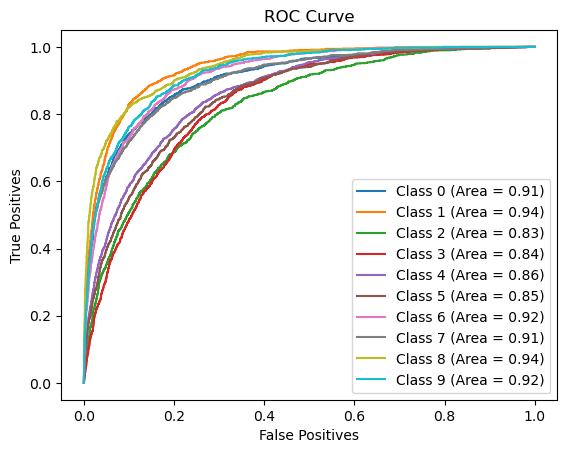

In [31]:
print("Average Area Under the Curve for Standard MLP: " + str(averageArea(mlpModel)))
plotCurves(mlpModel)

From the visualizations above, the standard MLP model has a lower average area under the curce than Model 4. Therefore, I can conclude that my Model 4 is better at classification than the standard MLP model.

# Exceptional Work

## Using Transfer Learning with Pre-Trained Weights

In [32]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.stats import chi2
import math

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

input_layer = keras.Input(shape=(32, 32, 3))

normalized_input = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

# Load the pre-trained MobileNetV2 model with weights from ImageNet
base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
)

base_model.trainable = False

resized_input = layers.experimental.preprocessing.Resizing(224, 224)(normalized_input)

base_output = base_model(resized_input)

global_average_pooling = layers.GlobalAveragePooling2D()(base_output)

dense = layers.Dense(64, activation='relu')(global_average_pooling)
dense = layers.Dense(16, activation='relu')(dense)

output_layer = layers.Dense(10, activation='softmax')(dense)

# Create and compile the model
model1_transfer_learning = keras.Model(inputs=input_layer, outputs=output_layer)
model1_transfer_learning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model1_transfer_learning.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

test_loss, test_acc = model1_transfer_learning.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)

y_pred_transfer_learning = model1_transfer_learning.predict(X_val)
y_pred_transfer_learning = np.argmax(y_pred_transfer_learning, axis=1)

transfer_learning_correct = np.sum((y_pred_transfer_learning == y_val))

critical_value_transfer_learning = transfer_learning_correct**2 / transfer_learning_correct

# Perform the chi-squared test and calculate the p-value
p_value_transfer_learning = 1 - chi2.cdf(math.sqrt(critical_value_transfer_learning), 1)

# Compare the p-values
print("P-value for transfer learning model:", p_value_transfer_learning)

Epoch 1/5
1500/1500 [==============================] - 279s 186ms/step - loss: 0.7404 - accuracy: 0.7461 - val_loss: 0.5850 - val_accuracy: 0.7897
Epoch 2/5
1500/1500 [==============================] - 279s 186ms/step - loss: 0.5515 - accuracy: 0.8083 - val_loss: 0.5900 - val_accuracy: 0.8033
Epoch 3/5
1500/1500 [==============================] - 280s 187ms/step - loss: 0.5058 - accuracy: 0.8233 - val_loss: 0.5483 - val_accuracy: 0.8142
Epoch 4/5
1500/1500 [==============================] - 279s 186ms/step - loss: 0.4755 - accuracy: 0.8337 - val_loss: 0.5529 - val_accuracy: 0.8060
Epoch 5/5
188/188 [==============================] - 31s 163ms/step - loss: 0.5691 - accuracy: 0.8093
Test accuracy: 0.809333324432373
188/188 [==============================] - 31s 163ms/step
P-value for transfer learning model: 1.1102230246251565e-16


Here, we see that the validation accuracy reaches a high at about 81% which is about the same as the test accuracy as well with a P-value very close to zero.

## Transfer Learning vs Best Model (Model 4)

In [33]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from scipy.stats import chi2
import math

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

input_layer = keras.Input(shape=(32, 32, 3))

normalized_input = layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

base_model = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
)

base_model.trainable = False

resized_input = layers.experimental.preprocessing.Resizing(224, 224)(normalized_input)

base_output = base_model(resized_input)

global_average_pooling = layers.GlobalAveragePooling2D()(base_output)

dense_transfer_learning = layers.Dense(64, activation='relu')(global_average_pooling)
dense_transfer_learning = layers.Dense(16, activation='relu')(dense_transfer_learning)

output_transfer_learning = layers.Dense(10, activation='softmax')(dense_transfer_learning)

model_transfer_learning = keras.Model(inputs=input_layer, outputs=output_transfer_learning)

model_transfer_learning.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_transfer_learning.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

# Evaluate the transfer learning model on the test set
test_loss_transfer_learning, test_acc_transfer_learning = model_transfer_learning.evaluate(X_test, y_test)
print("Transfer Learning Model Test Accuracy:", test_acc_transfer_learning)

# Predictions on the validation set using the best model (Model 4)
y_pred_model4 = model4.predict(X_val)b
y_pred_model4 = np.argmax(y_pred_model4, axis=1)

# Count the number of correct predictions for each model
model4_correct = np.sum((y_pred_model4 == y_val))

# Calculate the critical value for the chi-squared test
critical_value_model4 = model4_correct**2 / model4_correct

# Perform the chi-squared test and calculate the p-value
p_value_model4 = 1 - chi2.cdf(math.sqrt(critical_value_model4), 1)

# Compare the p-values
print("P-value for Model 4:", p_value_model4)
print("P-value for Transfer Learning Model:", test_acc_transfer_learning)

SyntaxError: invalid syntax (3757385519.py, line 44)

The P-value for both models are close to zero and therefor that shows me that they models are about the same.

## Visualize the Comparisons

AxisError: axis 1 is out of bounds for array of dimension 1

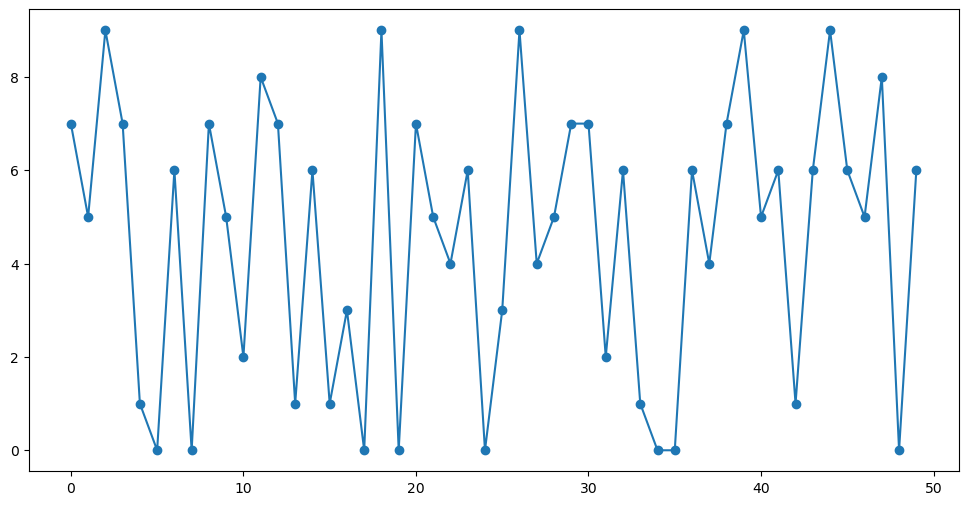

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming y_test contains true labels
y_test = np.array(y_test)

# Plotting the predicted values for Transfer Learning Model and Model 4
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='True Labels', marker='o')
plt.plot(np.argmax(y_pred_transfer_learning, axis=1)[:50], label='Transfer Learning Model', linestyle='--', marker='o')
plt.plot(np.argmax(y_pred_model4, axis=1)[:50], label='Model 4', linestyle='--', marker='o')

plt.title('Comparison of Predicted Values and True Labels')
plt.show()